In [1]:
import os.path
import matplotlib.pyplot as plt
from tensorflow.python import pywrap_tensorflow
import numpy as np
%matplotlib inline

In [2]:
path = '../activations'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
arr_hm = [np.empty([num_files,21,64], dtype=float),
            np.empty([num_files,21,64], dtype=float),
            np.empty([num_files,21,128], dtype=float),
            np.empty([num_files,21,128], dtype=float),
            np.empty([num_files,21,256], dtype=float),
            np.empty([num_files,21,256], dtype=float),
            np.empty([num_files,21,256], dtype=float),
            np.empty([num_files,21,512], dtype=float),
            np.empty([num_files,21,512], dtype=float),
            np.empty([num_files,21,512], dtype=float),
            np.empty([num_files,21,512], dtype=float),
            np.empty([num_files,21,512], dtype=float),
            np.empty([num_files,21,512], dtype=float)]
num_clas = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [3]:
print 'loading data from text files'
for filename in os.listdir(path):
#     print 'processing file {}'.format(filename)
    clas = []
    acts = []
    f = open('/'.join([path,filename]),'r')
    act_ind = 0
    for line in f.readlines():
        if line and line[0].isalpha():
            clas.append(line[:-1])
        if line.startswith('['):
            if not line.endswith(']/n'):
                acts.append([])
                acts_this_line = line[2:-1].split(' ')
                for i in acts_this_line:
                    if i is not '':
                        acts[act_ind].append(float(i))
            else:
                raise IOError('Error line with fewer numbers than expected.')
        if line.startswith(' '):
            # print 'starts with nothing'
            if line.endswith(']\n'):
                acts_this_line = line[:-2].split(' ')
                for i in acts_this_line:
                    if i is not '':
                        acts[act_ind].append(float(i))
                act_ind += 1
            else:
                acts_this_line = line.split(' ')
                for i in acts_this_line:
                    if i is not '':
                        acts[act_ind].append(float(i))

    for ind,item in enumerate(CLASSES[1:]):
        if item in clas:
            file_ind = int(filename[:-4])
            for j in range(13):
                arr_hm[j][file_ind][ind] += acts[j]
            num_clas[ind+1] = num_clas[ind+1] + 1
print 'loaded'

loading data from text files
loaded


In [8]:
print num_clas
print arr_hm[0].shape

[1, 472, 578, 659, 608, 655, 701, 1516, 654, 1773, 523, 898, 980, 720, 612, 2802, 796, 331, 1320, 609, 787]
(4952, 21, 64)


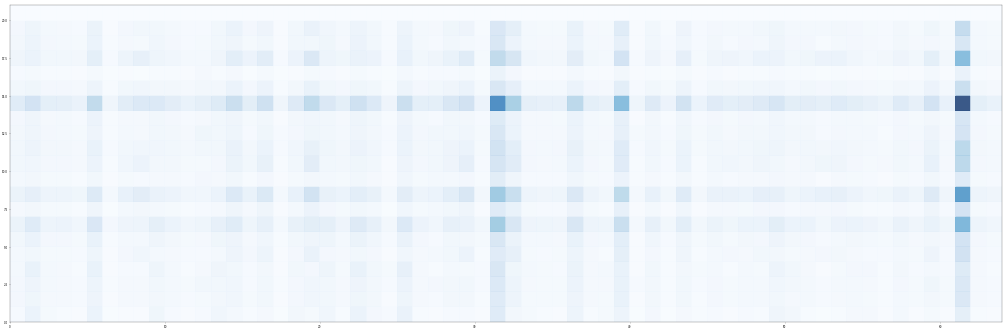

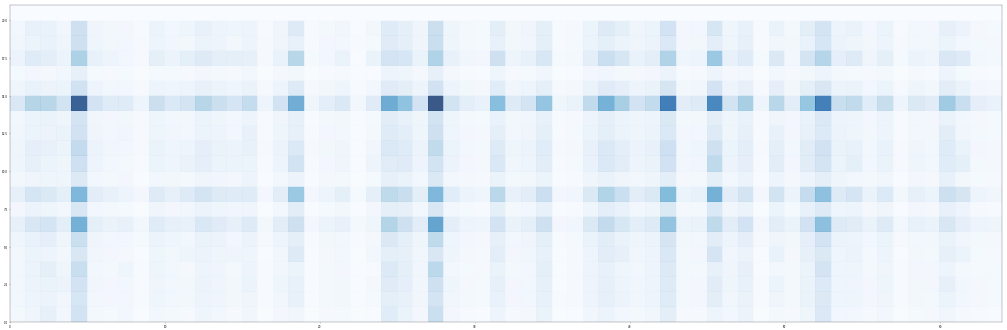

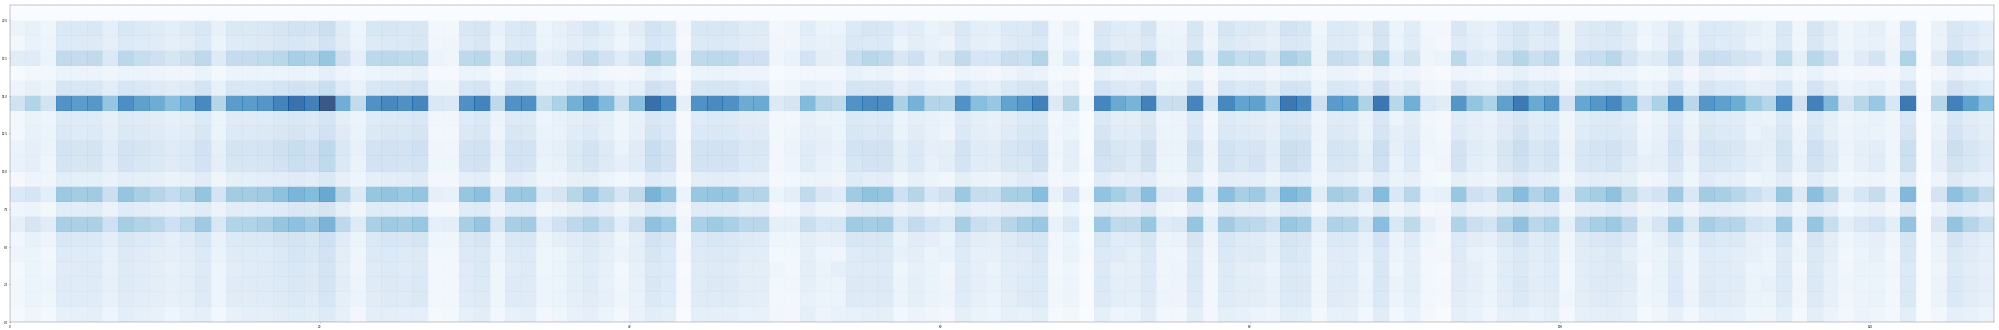

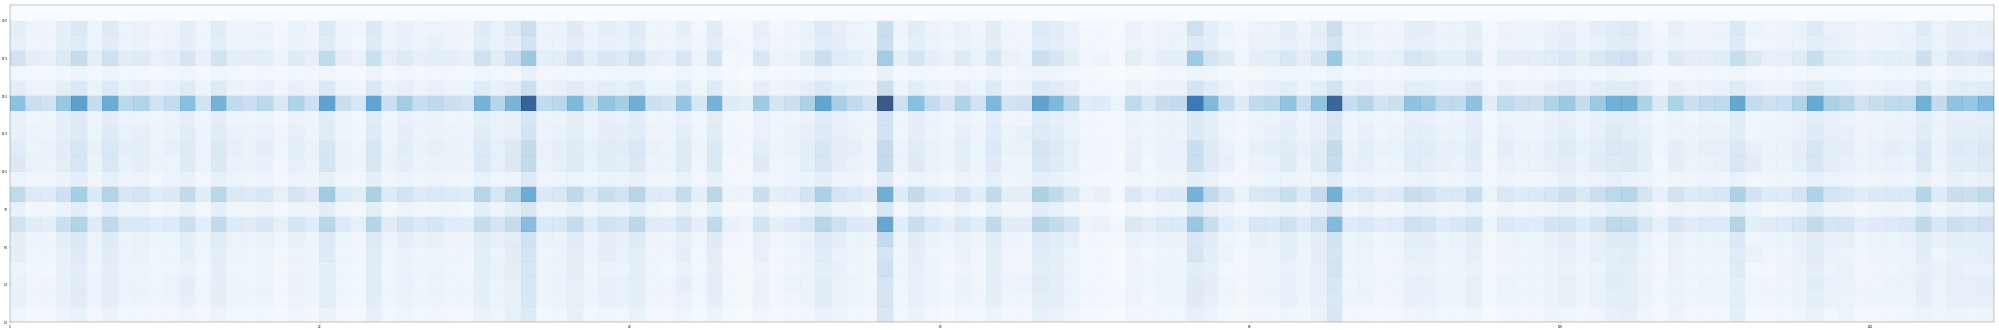

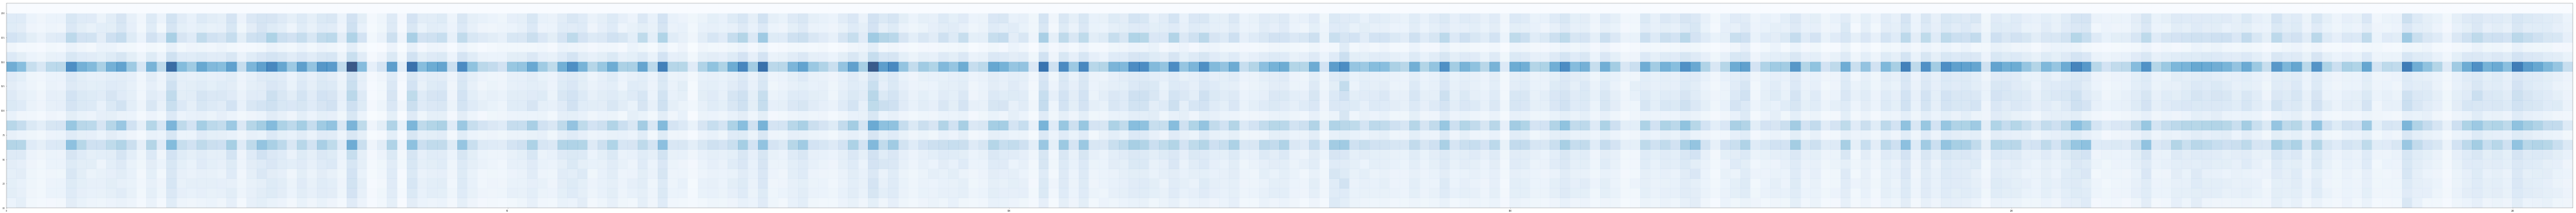

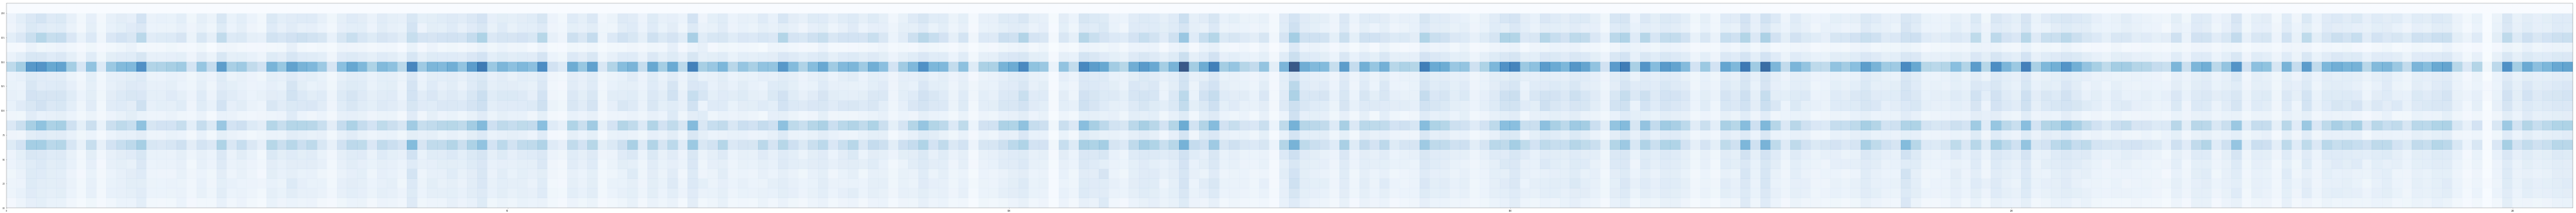

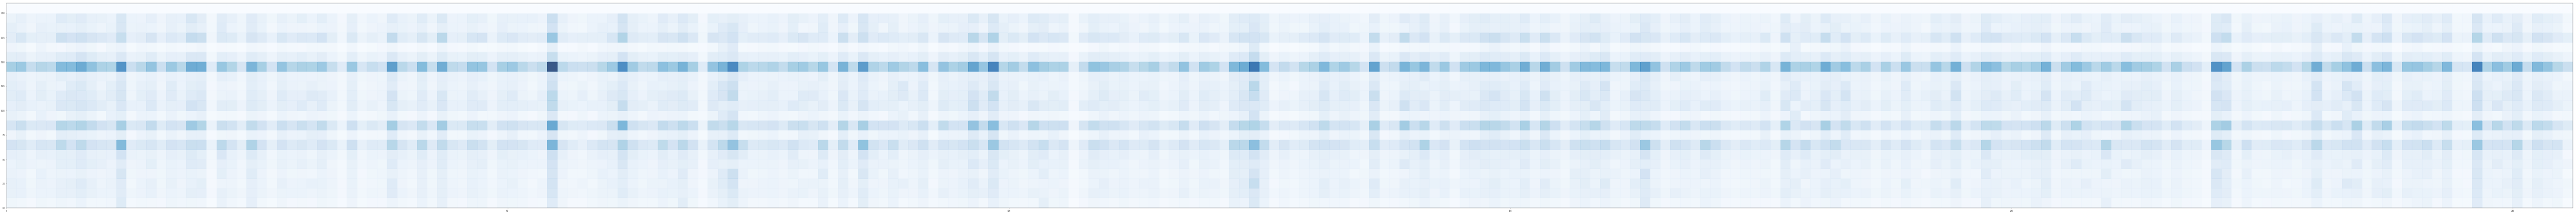

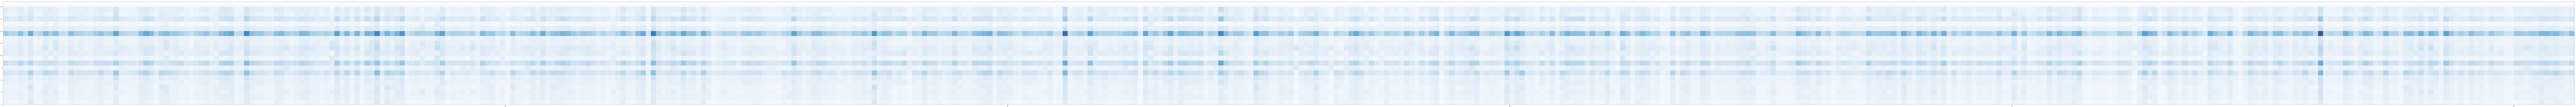

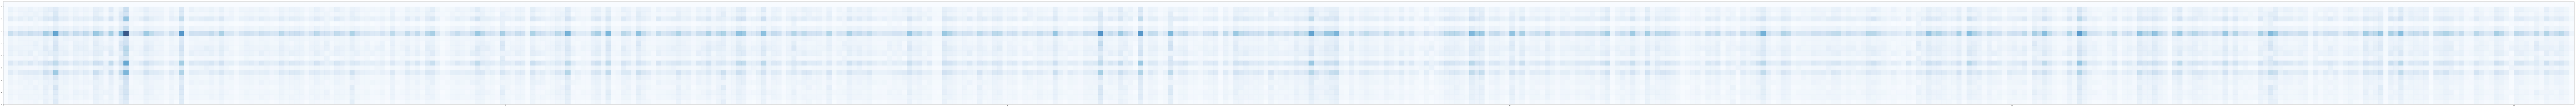

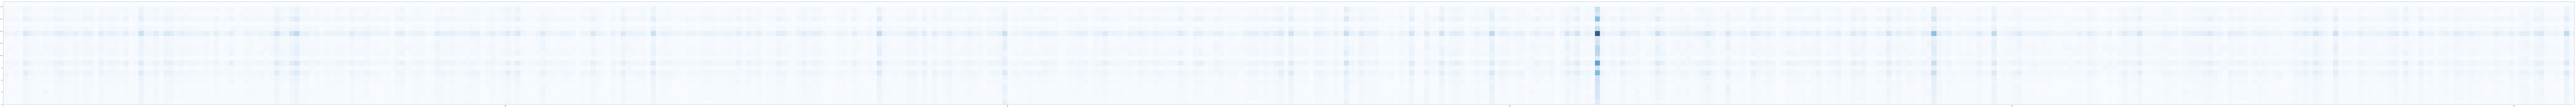

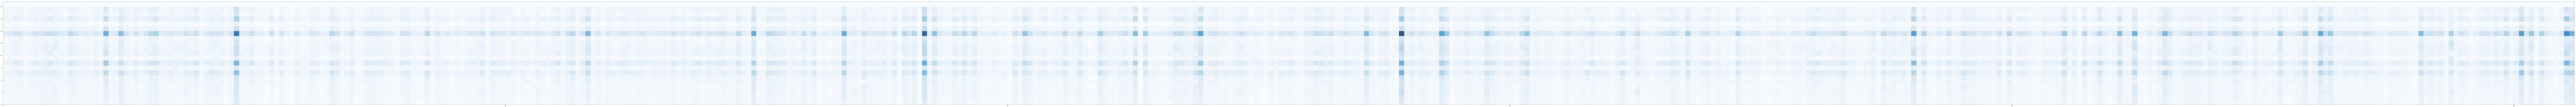

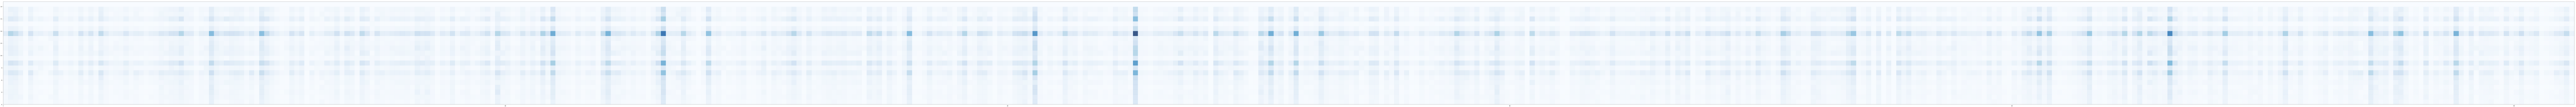

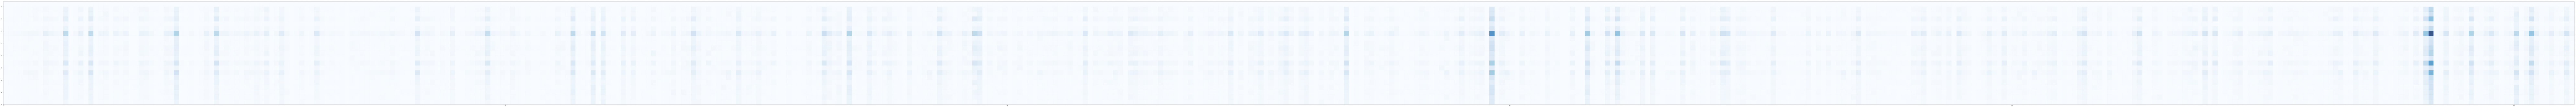

In [5]:
for i in range(13):
#     arr_hm_average = np.average(arr_hm[i],axis=0)
#     print arr_hm_average
    arr_hm_new = np.sum(arr_hm[i], axis=0)/num_clas[i]
#     print arr_hm_new.shape

    fig= plt.figure(figsize=(arr_hm_new.shape[1], 21), dpi= 20, facecolor='w', edgecolor='k')
    ax = plt.axes()
    plt.subplot()
    heatmap = ax.pcolormesh(arr_hm_new,cmap=plt.cm.Blues,alpha=0.8)
    plt.savefig('{}.png'.format(i))

In [6]:
# calcualates the corelations between classes
for i in range(13): 
#     arr_hm_average = np.average(arr_hm[i],axis=0)
#     print arr_hm_average
    arr_hm_new = np.sum(arr_hm[i], axis=0)/num_clas[i]
    cor_arr_hm = np.corrcoef(arr_hm_new[:-2])
#     print cor_arr_hm
    print np.average(cor_arr_hm[cor_arr_hm<1])

0.93784062124
0.946209615539
0.976846461633
0.961708072453
0.881188294643
0.87684713614
0.800487322982
0.744750907875
0.854841682964
0.911128362595
0.910979848164
0.925787301517
0.940666915393


In [6]:
print arr_hm[0].shape

(4952, 21, 64)


In [9]:
# read weights from the ckpt file
file_name = '../output/vgg16/voc_2007_trainval/default/vgg16_faster_rcnn_iter_70000.ckpt'
reader = pywrap_tensorflow.NewCheckpointReader(file_name)
var_to_shape_map = reader.get_variable_to_shape_map()
dic = {}
weights = []
for key in sorted(var_to_shape_map):
    if 'conv' in key and key.endswith('weights'):
        dic[key] = np.sum(reader.get_tensor(key),axis=(0,1,2))
        weights.append(dic[key])

In [10]:
# correlation between weights and activations
for i in range(13):
    arr_hm_new = np.sum(arr_hm[i], axis=(0,1))/num_clas[i]
#     print arr_hm_new.shape
    corr_weights_acts = np.corrcoef([weights[i],arr_hm_new])
    print corr_weights_acts[0][1]

-0.241854844706
0.74172162698
0.295600136712
0.57865594727
0.212262044496
0.116530647349
0.284733814161
-0.0203436521925
0.426106182637
0.187759750798
0.0643599813287
0.278986077559
0.373248292268


In [11]:
# correlation with AP for each class
APs = [0.689,0.784,0.675,0.534,0.586,0.786,0.841,0.839,0.478,0.814,0.669,0.807,0.841,0.756,0.771,0.462,0.707,0.670,0.742,0.731]
for i in range(13):
    arr_hm_new = np.sum(arr_hm[i], axis=(0,2))/num_clas[i]
    corr_weights_acts = np.corrcoef([APs,arr_hm_new[:-1][::-1]])
    print corr_weights_acts[0][1]


0.239447484772
0.237266522193
0.240250271087
0.238947568732
0.244961085818
0.236183296593
0.241612783161
0.237046238045
0.232828755235
0.228799777348
0.229274687099
0.223091723871
0.222368006522


In [12]:
# correlation with data amount for each class
for i in range(13):
    arr_hm_new = np.sum(arr_hm[i], axis=(0,2))/num_clas[i]
    corr_weights_acts = np.corrcoef([num_clas,arr_hm_new[::-1]])
    print corr_weights_acts[0][1]    

0.0546275915799
0.0532138974563
0.0580919728218
0.0625610016051
0.0546852471073
0.0568933412176
0.0565497546325
0.0520399278383
0.053187016696
0.0460796426889
0.0493262309279
0.045795142169
0.0574644856072
